# Plotting values in a gradient based on the MBH masses 

In [31]:
# Megan - had to add some of this in for testing the plotting code
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 16,
          'xtick.minor.size': 13,
          'ytick.major.size': 16,
          'ytick.minor.size': 13}
plt.rcParams.update(params)

In [89]:
#import plotly.express as px

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 16,
          'xtick.minor.size': 13,
          'ytick.major.size': 16,
          'ytick.minor.size': 13}
plt.rcParams.update(params)

import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

In [3]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

## Setting up the Data Tables to all be the same 

In [4]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')
#cosholes_df

In [6]:
# Megan - needed that data baby
cosholes_df = pd.read_csv('cosholes_df.csv')

In [5]:
#DATA frame for just the upper limits 

up_ch = cosholes_df.loc[(cosholes_df['uplim'] == 0)]
#up_ch

#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

sum_ch = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['uplim'] == 1)]
#sum_ch

#Df of all the components for the whole data set (use this for just the relative velocity plot) with no uplims 
com_ch = cosholes_df.loc[(cosholes_df['comp'] < 2) & (cosholes_df['uplim'] == 1)]
#com_ch

In [6]:
cos_sup = pd.concat([sum_ch, up_ch])
cos_sup = cos_sup.drop(['galaxy', 'zgal', 'Mhalo', 'SFR', 'vrel', 'line', 'wav', 'zsys', 'b', 'sigb', 'vel', 'sigvel', 'comp', 'Vhelio [km/s]'], axis=1)
cos_sup

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J1101,6.770,0.065,10.20,110.019140,273.43553,0.402359,13.403000,0.099000,1
1,J1159,8.255,0.125,10.43,37.385240,314.35077,0.118928,13.697000,0.074000,1
4,J1249,6.830,0.123,10.62,25.520224,363.76792,0.070155,14.311323,0.123487,1
8,J1051,8.400,0.071,10.79,40.499140,431.64653,0.093825,13.990000,0.057000,1
9,J1123,6.920,0.048,10.84,119.976000,458.29968,0.261785,14.012000,0.076000,1
10,J0246,8.140,0.090,10.50,55.657239,330.32571,0.168492,14.211000,0.053000,1
2,J1220,7.577,0.030,10.88,69.778997,482.42196,0.144643,13.650000,0.050000,0
3,J1222,7.577,0.030,10.88,130.305660,482.42196,0.270107,13.500000,0.050000,0
11,J1235,7.940,0.145,10.40,123.078500,308.12739,0.399440,13.380000,0.050000,0


### Note to Megan: you don't need to run anything from here till i say hi again at the end 

In [7]:
#M31 Data (Project AMIGA) Detections (and taking out the MS contaminations) 

amiga_2_det_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_det_sum.csv')
amiga_2_det_sum = amiga_2_det_sum.loc[(amiga_2_det_sum['sumlogN']!= 0)]
amiga_2_det_sum = amiga_2_det_sum.loc[amiga_2_det_sum['MS']==0]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
#making sure to use r200 as a substitute for since that is what we used 
amiga_m31_rvrir = 230 #kpc This is the value used for R200 in the paper? 

amiga_det_R = np.array(amiga_2_det_sum['Rad'])
amiga_det_RRvir = amiga_det_R/amiga_m31_rvrir

#amiga_2_det_sum

In [8]:
#M31 Data (Project AMIGA) non-detections (upper limits) and taking out the MS contamination
amiga_2_up_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_up_sum.csv')
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['sumlogN']!= 0)]
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['MS']== 0)]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
amiga_up_R = np.array(amiga_2_up_sum['Rad'])
amiga_up_RRvir = amiga_up_R/amiga_m31_rvrir

#amiga_2_up_sum

In [9]:
#making arrays of AMIGA MBH and error so that I can add to df 

#dets 
MBH_amiga = np.full(11, 8.15)
sigMBH_amiga = np.full(11, 0.24)
mstar_amiga = np.full(11, 10.3)
rvir_amiga = np.full(11,230)
uplim = np.full(11,1)

#ups
MBH_amiga_up = np.full(12, 8.15)
sigMBH_amiga_up = np.full(12, 0.24)
mstar_amiga_up = np.full(12, 10.3)
rvir_amiga_up = np.full(12,230)
uplim_up = np.full(12,0)

In [10]:
amiga_det = amiga_2_det_sum.drop(['index', 'z', 'RAdeg', 'Decdeg', 'ion', 'b_Vel', 'B_Vel', 'Vel', 'e_V', 'E_logN', 'e_logN', 'MS', 'sumlogN', 'f_logN'],axis=1)

amiga_det['amiga_det_RRvir'] = amiga_det_RRvir.tolist()
amiga_det['MBH_amiga'] = MBH_amiga.tolist()
amiga_det['sigMBH_amiga'] = sigMBH_amiga.tolist()
amiga_det['mstar_amiga'] = mstar_amiga.tolist()
amiga_det['rvir_amiga'] = rvir_amiga.tolist()
amiga_det['uplim'] = uplim.tolist()

amiga_det = amiga_det.rename(columns={'QSO': 'QSO', 'Rad': 'Rproj', 'logN': 'N', 'sum_elogN': 'sigN', 
                                      'amiga_det_RRvir': 'Rproj/Rvir', 'MBH_amiga': 'MBH', 'sigMBH_amiga': 'sigMBH', 'mstar_amiga': 'M*', 
                                     'rvir_amiga': 'Rvir','uplim': 'uplim'})

amiga_det = amiga_det.iloc[:,[0,5,6,7,1,8,4,2,3,9]]

#amiga_det

In [11]:
amiga_up = amiga_2_up_sum.drop(['index', 'z', 'RAdeg', 'Decdeg', 'ion', 'b_Vel', 'B_Vel', 'Vel', 'e_V', 'E_logN', 'e_logN', 'MS', 'sumlogN', 'f_logN'],axis=1)

amiga_up['amiga_up_RRvir'] = amiga_up_RRvir.tolist()
amiga_up['MBH_amiga_up'] = MBH_amiga_up.tolist()
amiga_up['sigMBH_amiga_up'] = sigMBH_amiga_up.tolist()
amiga_up['mstar_amiga_up'] = mstar_amiga_up.tolist()
amiga_up['rvir_amiga_up'] = rvir_amiga_up.tolist()
amiga_up['uplim_up'] = uplim_up.tolist()

amiga_up = amiga_up.rename(columns={'QSO': 'QSO', 'Rad': 'Rproj', 'logN': 'N', 'sum_elogN': 'sigN',
                                      'amiga_up_RRvir': 'Rproj/Rvir', 'MBH_amiga_up': 'MBH', 'sigMBH_amiga_up': 'sigMBH', 
                                    'mstar_amiga_up': 'M*', 'rvir_amiga_up': 'Rvir', 'uplim_up': 'uplim'})

amiga_up = amiga_up.iloc[:,[0,5,6,7,1,8,4,2,3,9]]

#amiga_up

In [12]:
amiga_sup = pd.concat([amiga_det, amiga_up])
amiga_sup = amiga_sup.loc[(amiga_sup['Rproj/Rvir'] <= 0.8)]
amiga_sup

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
3,HS0033+4300,8.15,0.24,10.3,30.5,230,0.132609,14.10,0.050000,1
4,HS0058+4213,8.15,0.24,10.3,48.6,230,0.211304,13.33,0.183848,1
6,RX_J0043.6+3725,8.15,0.24,10.3,50.5,230,0.219565,13.85,0.030000,1
7,Zw535.012,8.15,0.24,10.3,59.7,230,0.259565,12.99,0.300167,1
9,RX_J0050.8+3536,8.15,0.24,10.3,77.1,230,0.335217,13.45,0.070000,1
10,IRAS_F00040+4325,8.15,0.24,10.3,93.0,230,0.404348,13.23,0.106301,1
12,MRK352,8.15,0.24,10.3,131.7,230,0.572609,13.50,0.152971,1
15,KAZ238,8.15,0.24,10.3,150.2,230,0.653043,13.45,0.136015,1
1,RX_J0043.6+3725,8.15,0.24,10.3,50.5,230,0.219565,12.92,0.300000,0
5,RXS_J0118.8+3836,8.15,0.24,10.3,97.2,230,0.422609,12.90,0.420000,0


In [80]:
#Borthakur 2013 Data
#https://iopscience.iop.org/article/10.1088/0004-637X/768/1/18/pdf

borthakur = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/borthakur_2013.csv", sep=",")   
borthakur.sort_values('det', inplace=True)
#borthakur

#remove the zero value in the df 
borthakur_no_zero = borthakur.drop(labels=12, axis=0)
#print(borthakur_no_zero)

########################################################

#Bordoloi 2014 Data 
#https://iopscience.iop.org/article/10.1088/0004-637X/796/2/136/pdf

bordoloi = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/bordoloi_2014_CIV.csv", sep=",") 
bordoloi.sort_values('det', inplace=True)
#bordoloi

########################################################

#COS-Halos    

coshalos = {'QSO': ['J0910', 'J1619'],
            'sigMBH': [0.5, 0.5],
            'M*': [10.61, 10.10], 
            'Rproj': [112, 97], 
            'Rvir': [329, 249],
               'Rproj/Rvir': [0.34, 0.39],
               'N': [14.10, 13.90],
               'sigN': [0.09, 0.03], 
           'uplim': [1,1]}
COSHALOS = pd.DataFrame(data=coshalos)

## Setting up Stellar Mass Bins 

Since we are still seeing a null result I want to investigate how the stellar mass may be impacting the sample so will split the larger sample into a stellar mass bin that only has values between 10^10-11 and use data from 0-150 kpc (since that is where we see the most "consistency")

In [14]:
####### BORTHAKUR ######### => Only has high stellar mass bin values 

borthakur_less150 = borthakur_no_zero.loc[(borthakur_no_zero['rhokpc[i]'] <= 150)]
#borthakur_less150
borthakur_high = borthakur_less150.loc[(borthakur_less150['mstar[i]'] >= 10) & (borthakur_less150['mstar[i]'] <= 11)]
borthakur_high

,galname[i],mstar[i],alog10(mhalo[i]),rvir[i],rhokpc[i],rhokpc[i]/rvir[i],logNCIV[i],err,det
16,J154527.12+484642.2,10.50,12.029020,330.32571,64.7,0.195867,13.79,0.00,0
13,J132150.89+033034.1,10.81,12.408067,441.86569,140.2,0.317291,14.06,0.00,0
8,J102846.43+391842.9,10.50,12.029020,330.32571,88.7,0.268523,14.65,0.04,1
14,J140502.20+470525.9,10.43,11.964435,314.35077,146.9,0.467312,14.25,0.08,1


In [15]:
####### BORDOLOI ######### 

bordoloi_less150 = bordoloi.loc[(bordoloi['R[kpc]'] <= 150) & (bordoloi['logM*'] >= 9) ]
#bordoloi_less150

#separating into the stellar mass sample: 10-11
#bordoloi_low = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 9) & (bordoloi_less150['logM*'] < 10)]
    #Due to the new stellar mass bin idea, we don't need the bordoloi low
bordoloi_high = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 10.0) & (bordoloi_less150['logM*'] <= 11.0)]

bordoloi_high

,QSO,logNCIV,err,det,logM*,R[kpc],Rvir[kpc],R/Rvir
25,J1211+3657,13.17,0.00,0,10.1,90,272,0.330882
26,J1121+0325,13.45,0.00,0,10.1,89,277,0.321300
1,J09525+4535,13.56,0.06,1,10.0,95,259,0.366795
15,PG1202+281,13.58,0.10,1,10.0,92,254,0.362205
12,J0959+0503,14.69,0.00,2,10.0,14,247,0.056680


## Using the Velocity Dispersions of the Galaxy to calculate the MBH for each of our literature values

In [16]:
gals = fits.open('/Users/samgarza/Dropbox/COS-Holes/ArchivalData/gal_info_dr7_v5_2.fit')
gals.info()

Filename: /Users/samgarza/Dropbox/COS-Holes/ArchivalData/gal_info_dr7_v5_2.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     67   927552R x 25C   [I, J, I, 5I, E, E, 5E, I, I, 19A, 6A, 21A, E, E, I, E, E, E, E, E, E, 3E, 3E, 5E, 12A]   


In [17]:
gal_data = gals[1].data

In [18]:
#Values that I need to search for the vdisps for the specific galaxy/qso using from literature 

#BORDOLOI VALUES 
pids = np.array([2105, 511, 833, 2227, 995])
mjds = np.array([53472, 52636, 52314, 53820, 52731])
fids = np.array([407, 449, 104, 491, 208])

#BORTHAKUR VALUES 

pids_borth = np.array([1167, 526, 1430, 1285])
mjds_borth = np.array([52738, 52312, 53002, 52723])
fids_borth = np.array([638, 529, 237, 37])

In [19]:
#For Bordoloi
vdisps = []
vdisps_err = []

for i in range(len(pids)): 
    #Plate ID
    mask = gal_data.PLATEID == pids[i]
    check = gal_data[mask]

    #MJD
    mask2 = check.MJD == mjds[i]
    check = check[mask2]

    #FIBERID
    mask3 = check.FIBERID == fids[i]
    test = check[mask3]
    print(test.shape)
    
    print(f'V_DISP: {test.V_DISP}, V_DISP_ERR:{test.V_DISP_ERR}')
    
    vdisps.append(test.V_DISP)
    vdisps_err.append(test.V_DISP_ERR)
    
vdisps = np.array(vdisps)
vdisps = vdisps.reshape(5,)
#vdisps

vdisps_err = np.array(vdisps_err)
vdisps_err = vdisps_err.reshape(5,)
#vdisps_err

(1,)
V_DISP: [57.136898], V_DISP_ERR:[13.070264]
(1,)
V_DISP: [41.15367], V_DISP_ERR:[9.7062435]
(1,)
V_DISP: [43.57293], V_DISP_ERR:[7.5054946]
(1,)
V_DISP: [33.40527], V_DISP_ERR:[16.83185]
(1,)
V_DISP: [77.021416], V_DISP_ERR:[17.392845]


In [20]:
#For Borthakur
vdisps_borth = []
vdisps_err_borth = []

for i in range(len(pids_borth)): 
    #Plate ID
    mask = gal_data.PLATEID == pids_borth[i]
    check = gal_data[mask]

    #MJD
    mask2 = check.MJD == mjds_borth[i]
    check = check[mask2]

    #FIBERID
    mask3 = check.FIBERID == fids_borth[i]
    test = check[mask3]
    print(test.shape)
    
    print(f'V_DISP: {test.V_DISP}, V_DISP_ERR:{test.V_DISP_ERR}')
    
    vdisps_borth.append(test.V_DISP)
    vdisps_err_borth.append(test.V_DISP_ERR)
    
vdisps_borth = np.array(vdisps_borth)
vdisps_borth = vdisps_borth.reshape(4,)
#vdisps

vdisps_err_borth = np.array(vdisps_err_borth)
vdisps_err_borth = vdisps_err_borth.reshape(4,)
#vdisps_err

(1,)
V_DISP: [76.28716], V_DISP_ERR:[17.076445]
(1,)
V_DISP: [148.91199], V_DISP_ERR:[7.8888116]
(1,)
V_DISP: [121.198685], V_DISP_ERR:[18.669765]
(1,)
V_DISP: [134.5503], V_DISP_ERR:[24.878817]


### Using Equation (7) from Piotrowska et al 2022 to take the velocity dispersions that we just found and get the MBH 
(https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.1052P/abstract)

In [21]:
#BORDOLOI MBH AND ERROR
logMBH_bord = (5.246 * np.log10(vdisps)) - 3.77 #epsilon = 0.417
#logMBH_bord

logMBH_bord_err_down = (5.246 * np.log10(vdisps - vdisps_err)) - 3.77 #epsilon = 0.417
#logMBH_bord_err_down

logMBH_bord_err_up = (5.246 * np.log10(vdisps + vdisps_err)) - 3.77 #epsilon = 0.417
#logMBH_bord_err_up

logMBH_bord_err = (logMBH_bord_err_down+logMBH_bord_err_up)/2
#logMBH_bord_err

In [22]:
#BORDOLOI MBH AND ERROR
logMBH_borth = (5.246 * np.log10(vdisps_borth)) - 3.77 #epsilon = 0.417
#logMBH_borth

logMBH_borth_err_down = (5.246 * np.log10(vdisps_borth - vdisps_err_borth)) - 3.77 #epsilon = 0.417
#logMBH_borth_err_down

logMBH_borth_err_up = (5.246 * np.log10(vdisps_borth + vdisps_err_borth)) - 3.77 #epsilon = 0.417
#logMBH_borth_err_up

logMBH_borth_err = (logMBH_borth_err_down+logMBH_borth_err_up)/2
#logMBH_borth_err

In [81]:
#COS-Halos MBH

vdisp_halos = np.array([154, 78])

logMBH_halo = (5.246 * np.log10(vdisp_halos)) - 3.77 #epsilon = 0.417
logMBH_halo

array([7.7057337 , 6.15592829])

In [23]:
#Adding the mbhs to the literature tables (that have been shortened due to stellar mass) 

#For the sum values 
mini_borth= {'MBH': logMBH_borth,
             'MBH_err': logMBH_borth_err}
mini_borth = pd.DataFrame(data=mini_borth)
#mini_borth

In [24]:
#For the sum values 
mini_bord= {'MBH': logMBH_bord,
             'MBH_err': logMBH_bord_err}
mini_bord = pd.DataFrame(data=mini_bord)
#mini_bord

In [25]:
#All the data for Borthakur
borthakur_new = pd.concat([borthakur_high.reset_index(drop=True), mini_borth], axis=1)
#borthakur_new

borth_sup = borthakur_new.drop(['alog10(mhalo[i])'], axis=1)
borth_sup = borth_sup.rename(columns={"galname[i]": "QSO", "MBH": "MBH", "MBH_err": "sigMBH","mstar[i]": "M*",
                         "rhokpc[i]": "Rproj", "rvir[i]": "Rvir", "rhokpc[i]/rvir[i]": "Rproj/Rvir",
                         "logNCIV[i]": "N", "err": "sigN", "det": "uplim",})
borth_sup = borth_sup.iloc[:,[0,8,9,1,3,2,4,5,6,7]]
borth_sup

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J154527.12+484642.2,6.105340,6.046782,10.50,64.7,330.32571,0.195867,13.79,0.00,0
1,J132150.89+033034.1,7.629189,7.625987,10.81,140.2,441.86569,0.317291,14.06,0.00,0
2,J102846.43+391842.9,7.160030,7.132673,10.50,88.7,330.32571,0.268523,14.65,0.04,1
3,J140502.20+470525.9,7.398128,7.358500,10.43,146.9,314.35077,0.467312,14.25,0.08,1


In [26]:
#Split into det and non det 

borth_det = borth_sup.loc[(borthakur_new['det'] == 1)]
#borth_det

borth_uplim = borth_sup.loc[(borthakur_new['det'] == 0)]
#borth_uplim

In [27]:
#All the data for Bordoloi
bordoloi_new = pd.concat([bordoloi_high.reset_index(drop=True), mini_bord], axis=1)
#bordoloi_new

bord_sup = bordoloi_new.rename(columns={"QSO": "QSO", "logNCIV": "N", "err": "sigN","det": "uplim",
                         "logM*": "M*", "R[kpc]": "Rproj", "Rvir[kpc]": "Rvir",
                         "R/Rvir": "Rproj/Rvir", "MBH": "MBH", "MBH_err": "sigMBH",})
bord_sup = bord_sup.iloc[:,[0,8,9,4,5,6,7,1,2,3]]
bord_sup

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J1211+3657,5.446784,5.385558,10.1,90,272,0.330882,13.17,0.00,0
1,J1121+0325,4.699188,4.633988,10.1,89,277,0.321300,13.45,0.00,0
2,J09525+4535,4.829331,4.795020,10.0,95,259,0.366795,13.56,0.06,1
3,PG1202+281,4.223933,3.890306,10.0,92,254,0.362205,13.58,0.10,1
4,J0959+0503,6.127163,6.067540,10.0,14,247,0.056680,14.69,0.00,2


In [28]:
bord_det = bord_sup.loc[(bordoloi_new['det'] == 1)]
#bord_det

bord_uplim = bord_sup.loc[(bordoloi_new['det'] == 0)]
#bord_uplim

bord_lolim = bord_sup.loc[(bordoloi_new['det'] == 2)]
#bord_lolim

In [82]:
COSHALOS.insert(loc = 1,
          column = 'MBH',
          value = logMBH_halo)
COSHALOS

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J0910,7.705734,0.5,10.61,112,329,0.34,14.1,0.09,1
1,J1619,6.155928,0.5,10.10,97,249,0.39,13.9,0.03,1


## Looking at the plots 

In [139]:
amiga_sup.shape

(13, 10)

In [128]:
coslit = pd.concat([cos_sup, borth_sup, bord_sup, COSHALOS, amiga_sup])
coslit

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J1101,6.770000,0.065000,10.20,110.019140,273.43553,0.402359,13.403000,0.099000,1
1,J1159,8.255000,0.125000,10.43,37.385240,314.35077,0.118928,13.697000,0.074000,1
4,J1249,6.830000,0.123000,10.62,25.520224,363.76792,0.070155,14.311323,0.123487,1
8,J1051,8.400000,0.071000,10.79,40.499140,431.64653,0.093825,13.990000,0.057000,1
9,J1123,6.920000,0.048000,10.84,119.976000,458.29968,0.261785,14.012000,0.076000,1
10,J0246,8.140000,0.090000,10.50,55.657239,330.32571,0.168492,14.211000,0.053000,1
2,J1220,7.577000,0.030000,10.88,69.778997,482.42196,0.144643,13.650000,0.050000,0
3,J1222,7.577000,0.030000,10.88,130.305660,482.42196,0.270107,13.500000,0.050000,0
11,J1235,7.940000,0.145000,10.40,123.078500,308.12739,0.399440,13.380000,0.050000,0
0,J154527.12+484642.2,6.105340,6.046782,10.50,64.700000,330.32571,0.195867,13.790000,0.000000,0


### Note to Megan: Hi again! 
all that other stuff is to get the literature information and their MBHs, but if I can get this working for my COS data then I should be able to get the other ones to work (just didn't want you to have to download a bunch of files that you didn't need 

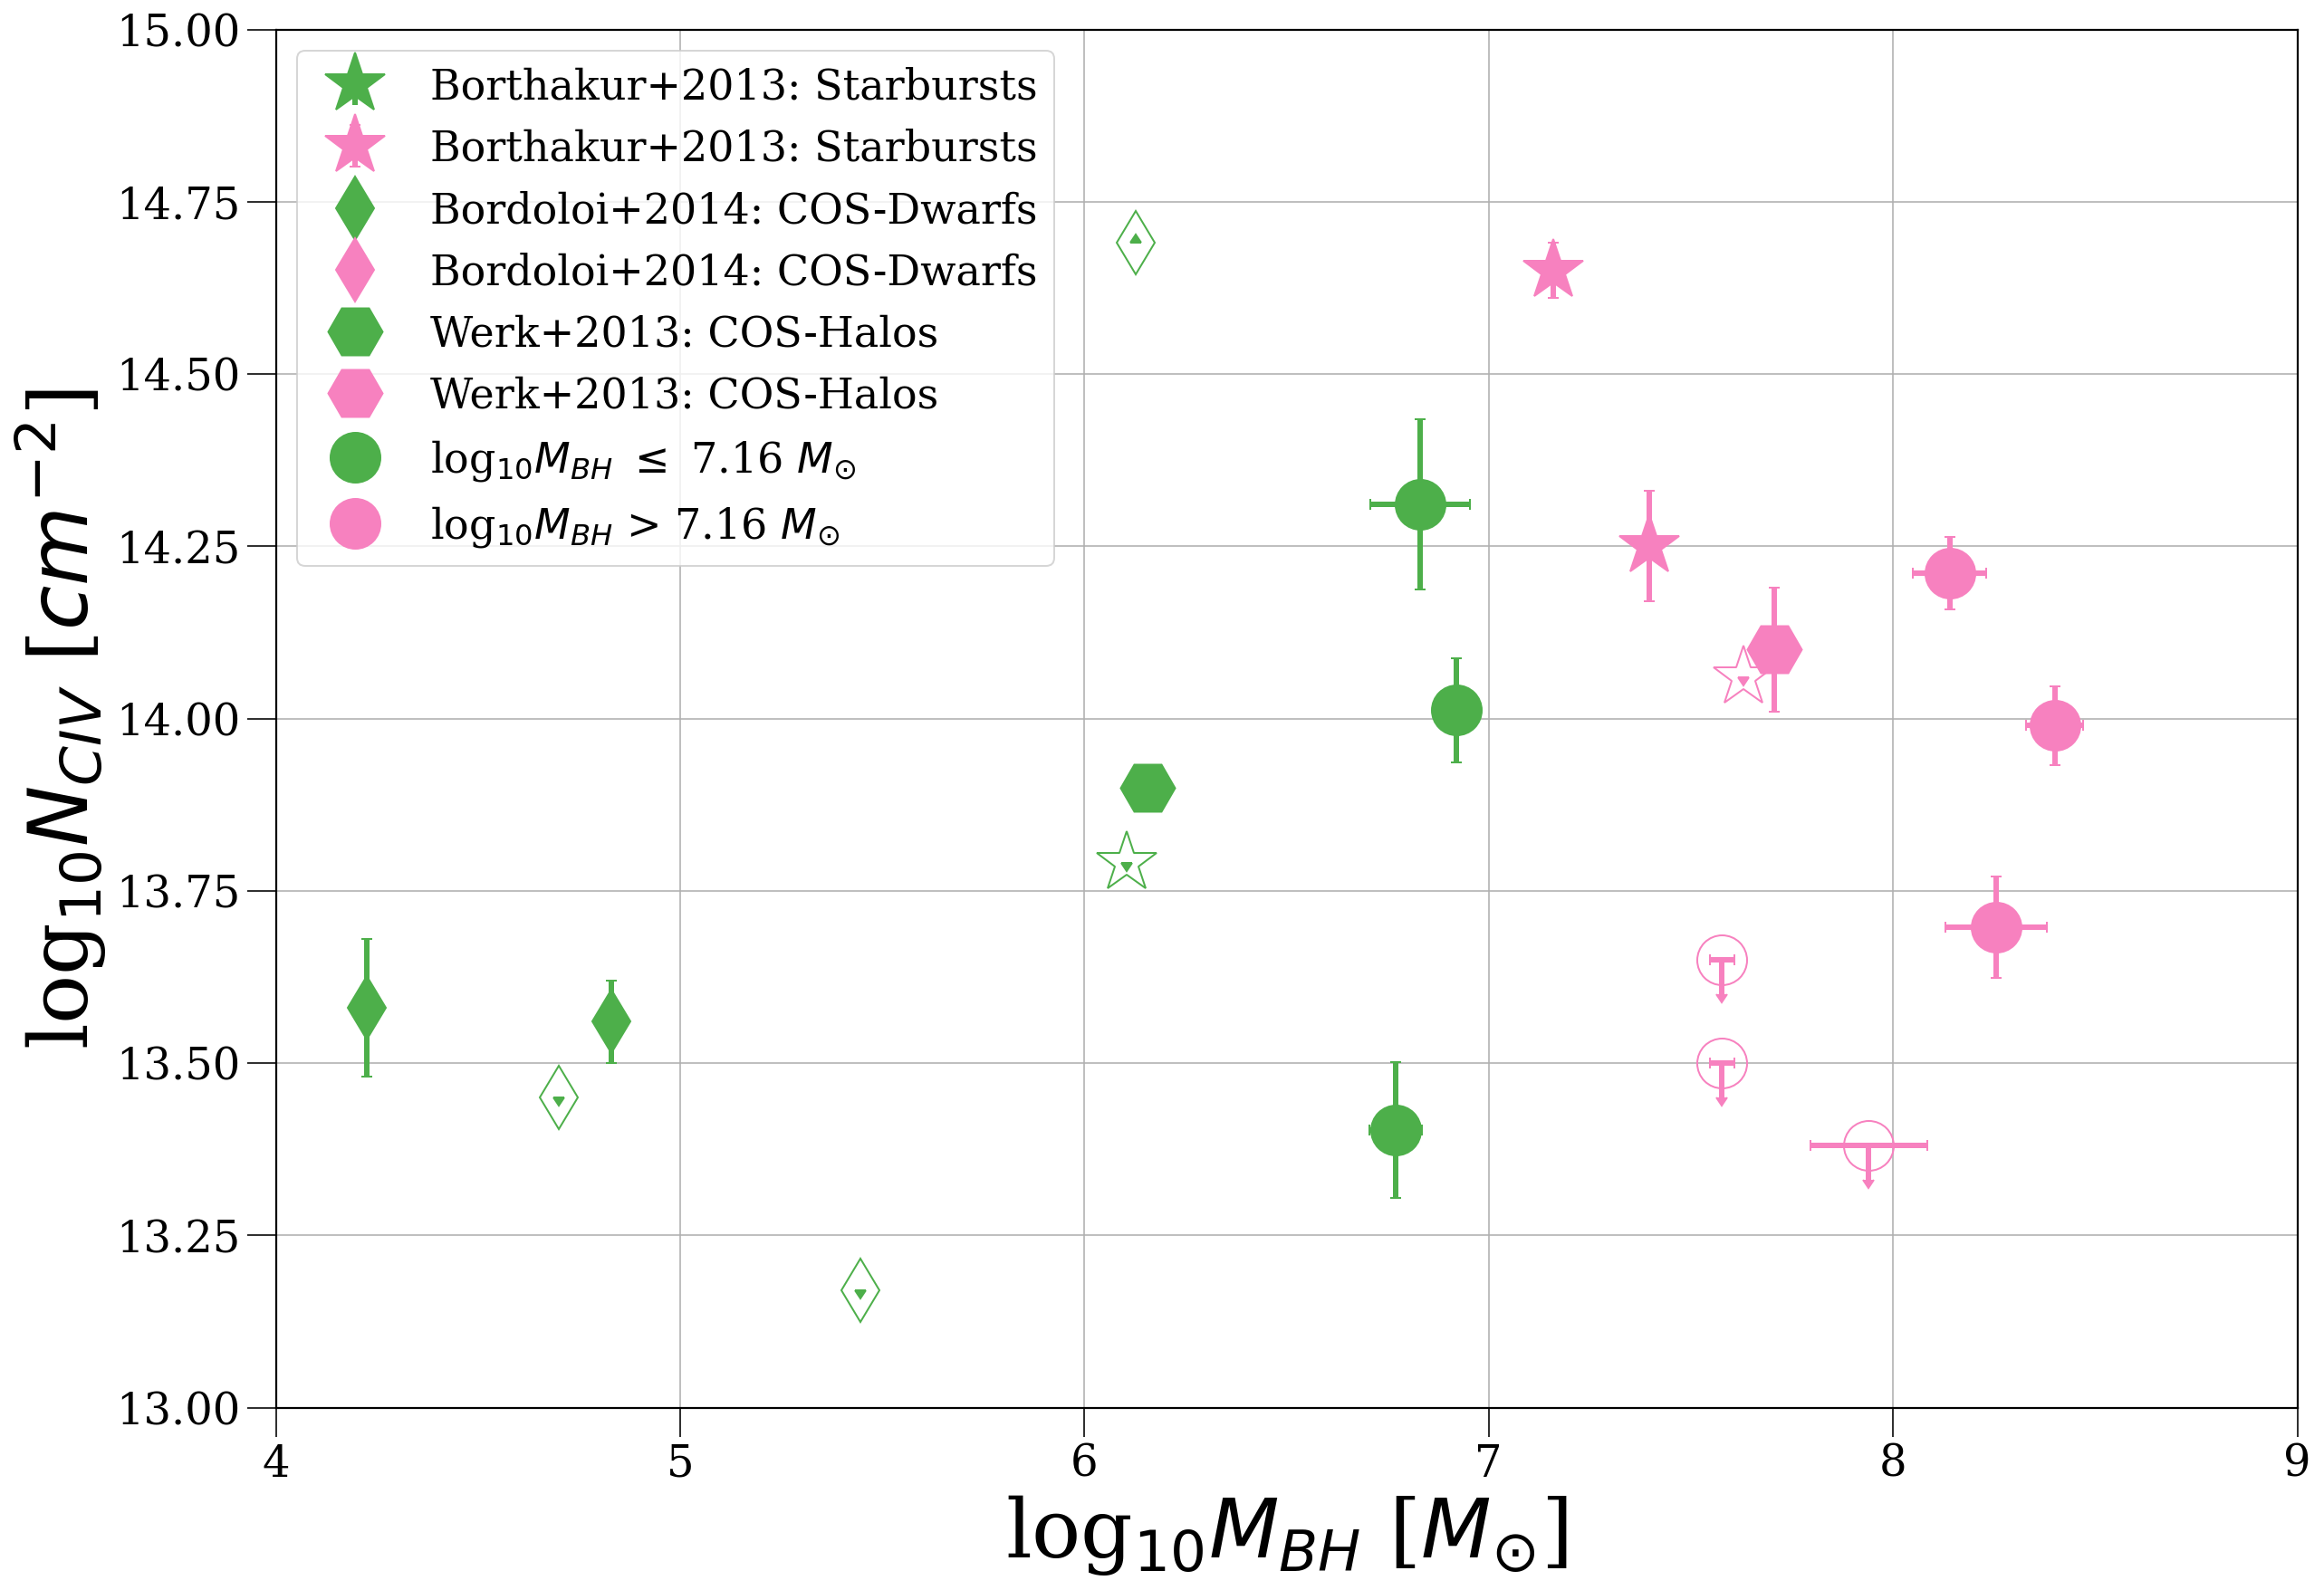

In [85]:
#This is what the plot looks like currently and I want to change the colors to be a gradient color bar 

low_mask, high_mask = (cosholes_df["MBH"] <= 7.16), (cosholes_df["MBH"] > 7.16)
#Creating masks for literature 

low_mask_borth, high_mask_borth = (borthakur_new["MBH"] <= 7.16), (borthakur_new["MBH"] > 7.16)
low_mask_bord, high_mask_bord = (bordoloi_new["MBH"] <= 7.16), (bordoloi_new["MBH"] > 7.16)
low_mask_halos, high_mask_halos = (COSHALOS["MBH"] <= 7.16), (COSHALOS["MBH"] > 7.16)

#Plotting NCIV vs MBH    
fig, ax = plt.subplots()

######################################################

########################################################

########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth, high_mask_borth], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Borthakur+2013: Starbursts", 
                                r"Borthakur+2013: Starbursts"]):
    
    ax.errorbar(borth_det['MBH'][mask], borth_det['N'][mask],yerr=borth_det['sigN'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=35, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(borth_uplim['MBH'][mask], borth_uplim['N'][mask],yerr=borth_uplim['sigN'][mask], #xerr=borth_uplim['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=35, ls='none', uplims=True, mfc='none', elinewidth=3)
    
########## Bordoloi ##########
    
for mask, colour, label in zip([low_mask_bord, high_mask_bord], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Bordoloi+2014: COS-Dwarfs", 
                                r"Bordoloi+2014: COS-Dwarfs"]):
    
    ax.errorbar(bord_det['MBH'][mask], bord_det['N'][mask],yerr=bord_det['sigN'][mask], #xerr=bord_det['MBH_err'][mask],
                capsize = 3, c = colour, marker="d", markersize=25, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(bord_uplim['MBH'][mask], bord_uplim['N'][mask],yerr=bord_uplim['sigN'][mask], #xerr=bord_uplim['MBH_err'][mask],
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', uplims=True, mfc='none', elinewidth=3)
    
    ax.errorbar(bord_lolim['MBH'][mask], bord_lolim['N'][mask],yerr=bord_lolim['sigN'][mask], #xerr=bord_lolim['MBH_err'][mask],
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', lolims=True, mfc='none', elinewidth=3)
    
########## COS-HAlOS ##########

for mask, colour, label in zip([low_mask_halos, high_mask_halos], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Werk+2013: COS-Halos", 
                                r"Werk+2013: COS-Halos"]):
    
    ax.errorbar(COSHALOS['MBH'][mask], COSHALOS['N'][mask],yerr=COSHALOS['sigN'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 3, c = colour, marker="H", markersize=30, label=label, ls='none', elinewidth=3)

########################################################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.16 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.16 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["MBH"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["MBH"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)
    

ax.legend(loc=2, fontsize=23)
ax.set_xlabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(13, 15)
ax.set_xlim(4, 9)
plt.grid(True)
#plt.savefig('Figures/nciv_vs_bh.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


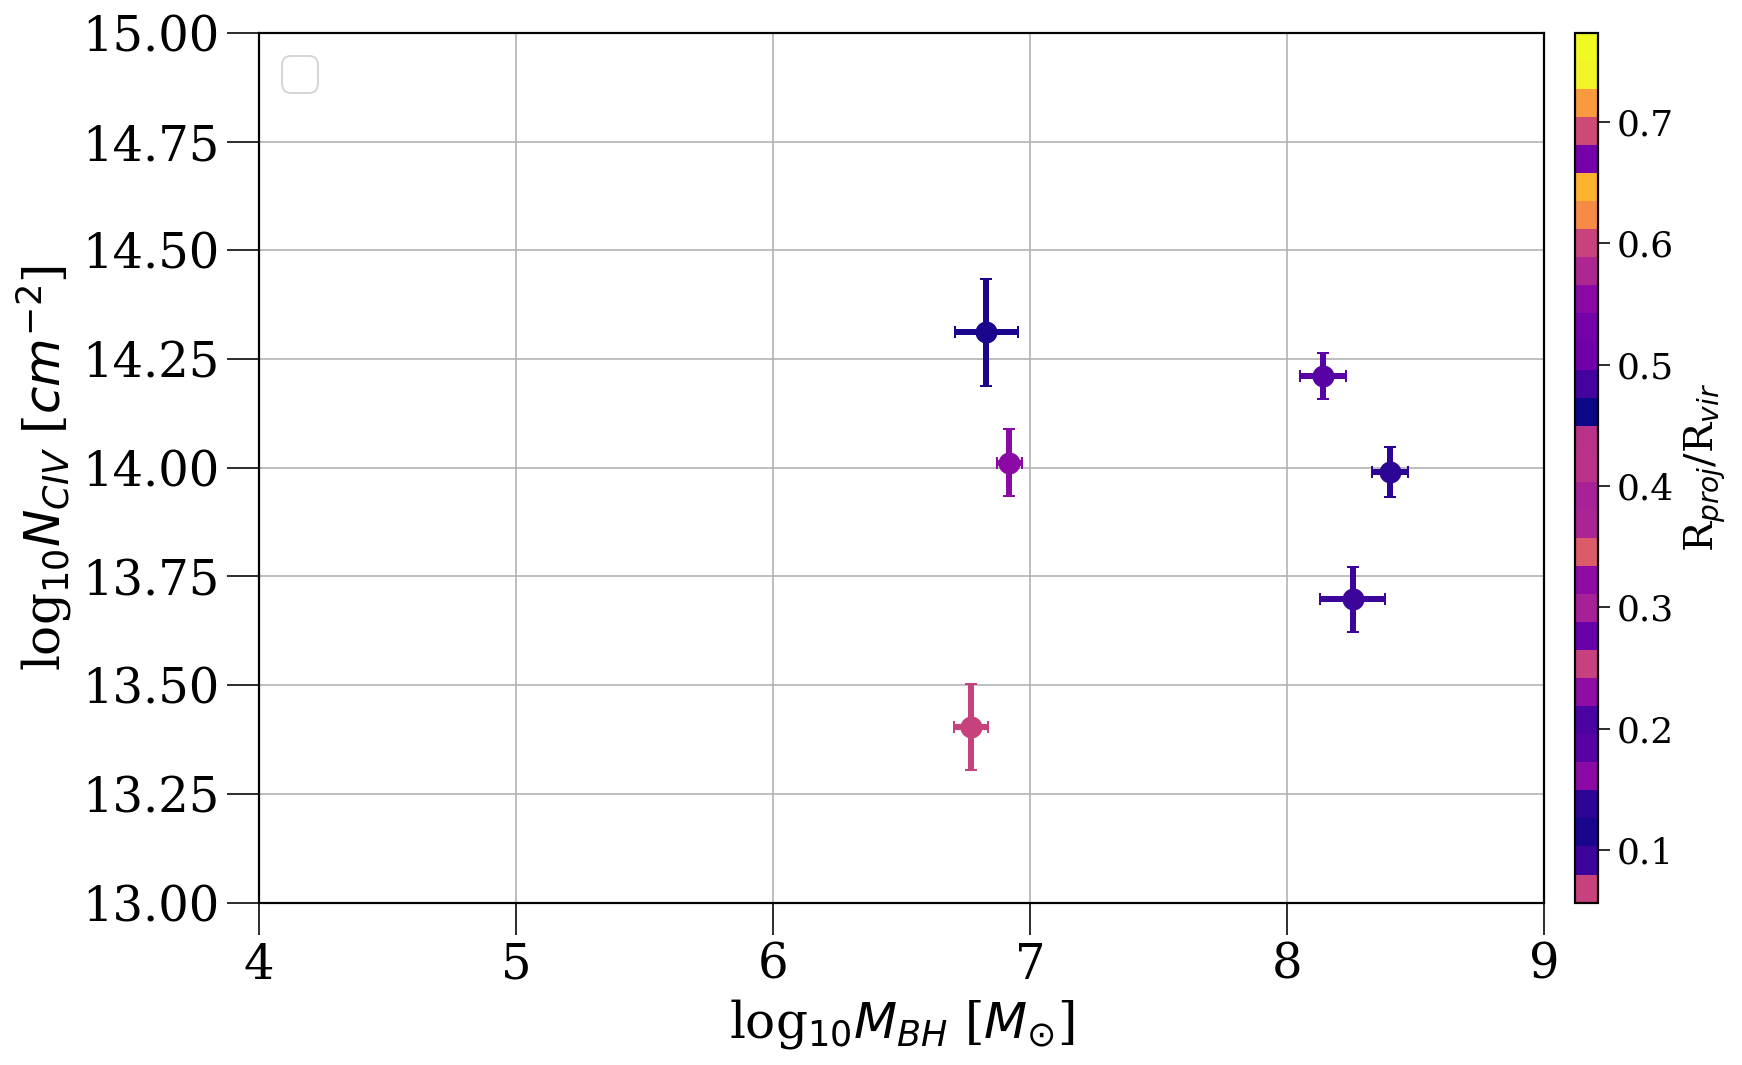

In [86]:
# ur gonna need this boi
import matplotlib as mpl

# Set figure size, I like this for 1 plot w colorbar but yaknow whateva
fig = plt.figure(figsize=(12,8))

# Set a grid on your figure so you can define the color bar axis
# This is basically dividing your figure into rows,columns
# I put a lot of columns so the colorbar will be narrow
axs = fig.add_gridspec(1, 50)

# Define the plot and the colorbar axes
# This is totally up to preference, you could leave a column empty...
# ... if you wanted a little extra space between the two
# you just tell it width by the # of columns on the grid you define
# So basically play around with the grid (axs) and the subplots below...
# ... until you get a layout with dimensions you like
plot = fig.add_subplot(axs[0, 0:48]) # this means use cols 0 - 49
cbar = fig.add_subplot(axs[0, 49])

# Now lets get the colors for ur points, luckily you have the values ...
# ... you want the colors to correspond to defined above as array 'c'
# Then we will normalize the color bar to the min/max value of that...
# ... array so it looks nice
plasma = plt.cm.get_cmap('plasma')
# We need to make the c array be 0 -1 normalized so the colors are right
# This only needs to be done if you want the distance to be preserved as ...
# ... a gradient function of Rproj/Rvir
# since you have so few points though, that doesn't really matter
# so you could do a discrete color bar, which would just be equally spaced points ...
# ... spanning the entire range of the colorbar
# And the labels on the colorbar would indicate the value of Rproj/Rvir
# To do that, just replace "c_normed" with "np.linspace(0, 1, len(c))"
# below you'll see two colorbar display options that I've commented out
# One is discrete, only showing your points colors
# The other is a continous gradient which your points come from
# you'll see what I mean, just test it with each 'cmap' line below ...
# ... before you mess with this stuff if you decide you want it discrete
c_normed = (c-min(c))/(max(c)-min(c))
coloring = plasma(c_normed) # you can replace plasma with whatev


# Okay now plotting, same as above but made the color our new defined one
# It gets mad at you without the loop cuz its dumb
# Because of the way you've defined your variables ...
# ... with pandas and masks, you need to make them arrays ...
# ... for this to work, which I did here
mbh_arr = np.array(sum_ch['MBH'])
N_arr = np.array(sum_ch['N'])
sigN_arr = np.array(sum_ch['sigN'])
sigmbh_arr = np.array(sum_ch['sigMBH'])

for i in range(len(mbh_arr)):
    plot.errorbar(mbh_arr[i], N_arr[i], 
                yerr=sigN_arr[i], xerr = sigmbh_arr[i], 
                capsize = 3, c=coloring[i], marker=".", 
                markersize=20, ls='none', elinewidth=3)
# I changed some of your sizes cause they looked too big with my code ig

# Here's where the magic happens
# Set up normalization for the color bar
# (sets lowest color to min value and highest color to max value)
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))

# make the color bar
cmap = mpl.colors.ListedColormap(coloring, name='Rproj/Rvir')

# !!!!! Use this instead to make the colorbar look continuous gradient:
#cmap = plasma

# mapping for the color bar
mapping = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# do the thing, telling it to use the subplot you created for the ...
# ... color bar (cax = cbar)
colorbar = fig.colorbar(mapping, cax=cbar, orientation='vertical')

# Okay now it's created, the rest is just visual preference:
colorbar.ax.tick_params(length=6, labelsize=18)
colorbar.ax.spines['top'].set_linewidth(1.5)
colorbar.ax.spines['bottom'].set_linewidth(1.5)
colorbar.ax.spines['left'].set_linewidth(1.5)
colorbar.ax.spines['right'].set_linewidth(1.5)
colorbar.set_label(label=r'R$_{proj}$/R$_{vir}$', size=20)

# Your other stylings from above:
plot.legend(loc=2, fontsize=23) # Theres no labels for your legend but ill leave it
plot.set_xlabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=25)
plot.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=25)
plot.set_ylim([13, 15])
plot.set_xlim([4, 9])
plot.grid(True)
#plt.tight_layout()
plt.show()

In [93]:
has_UL

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True])

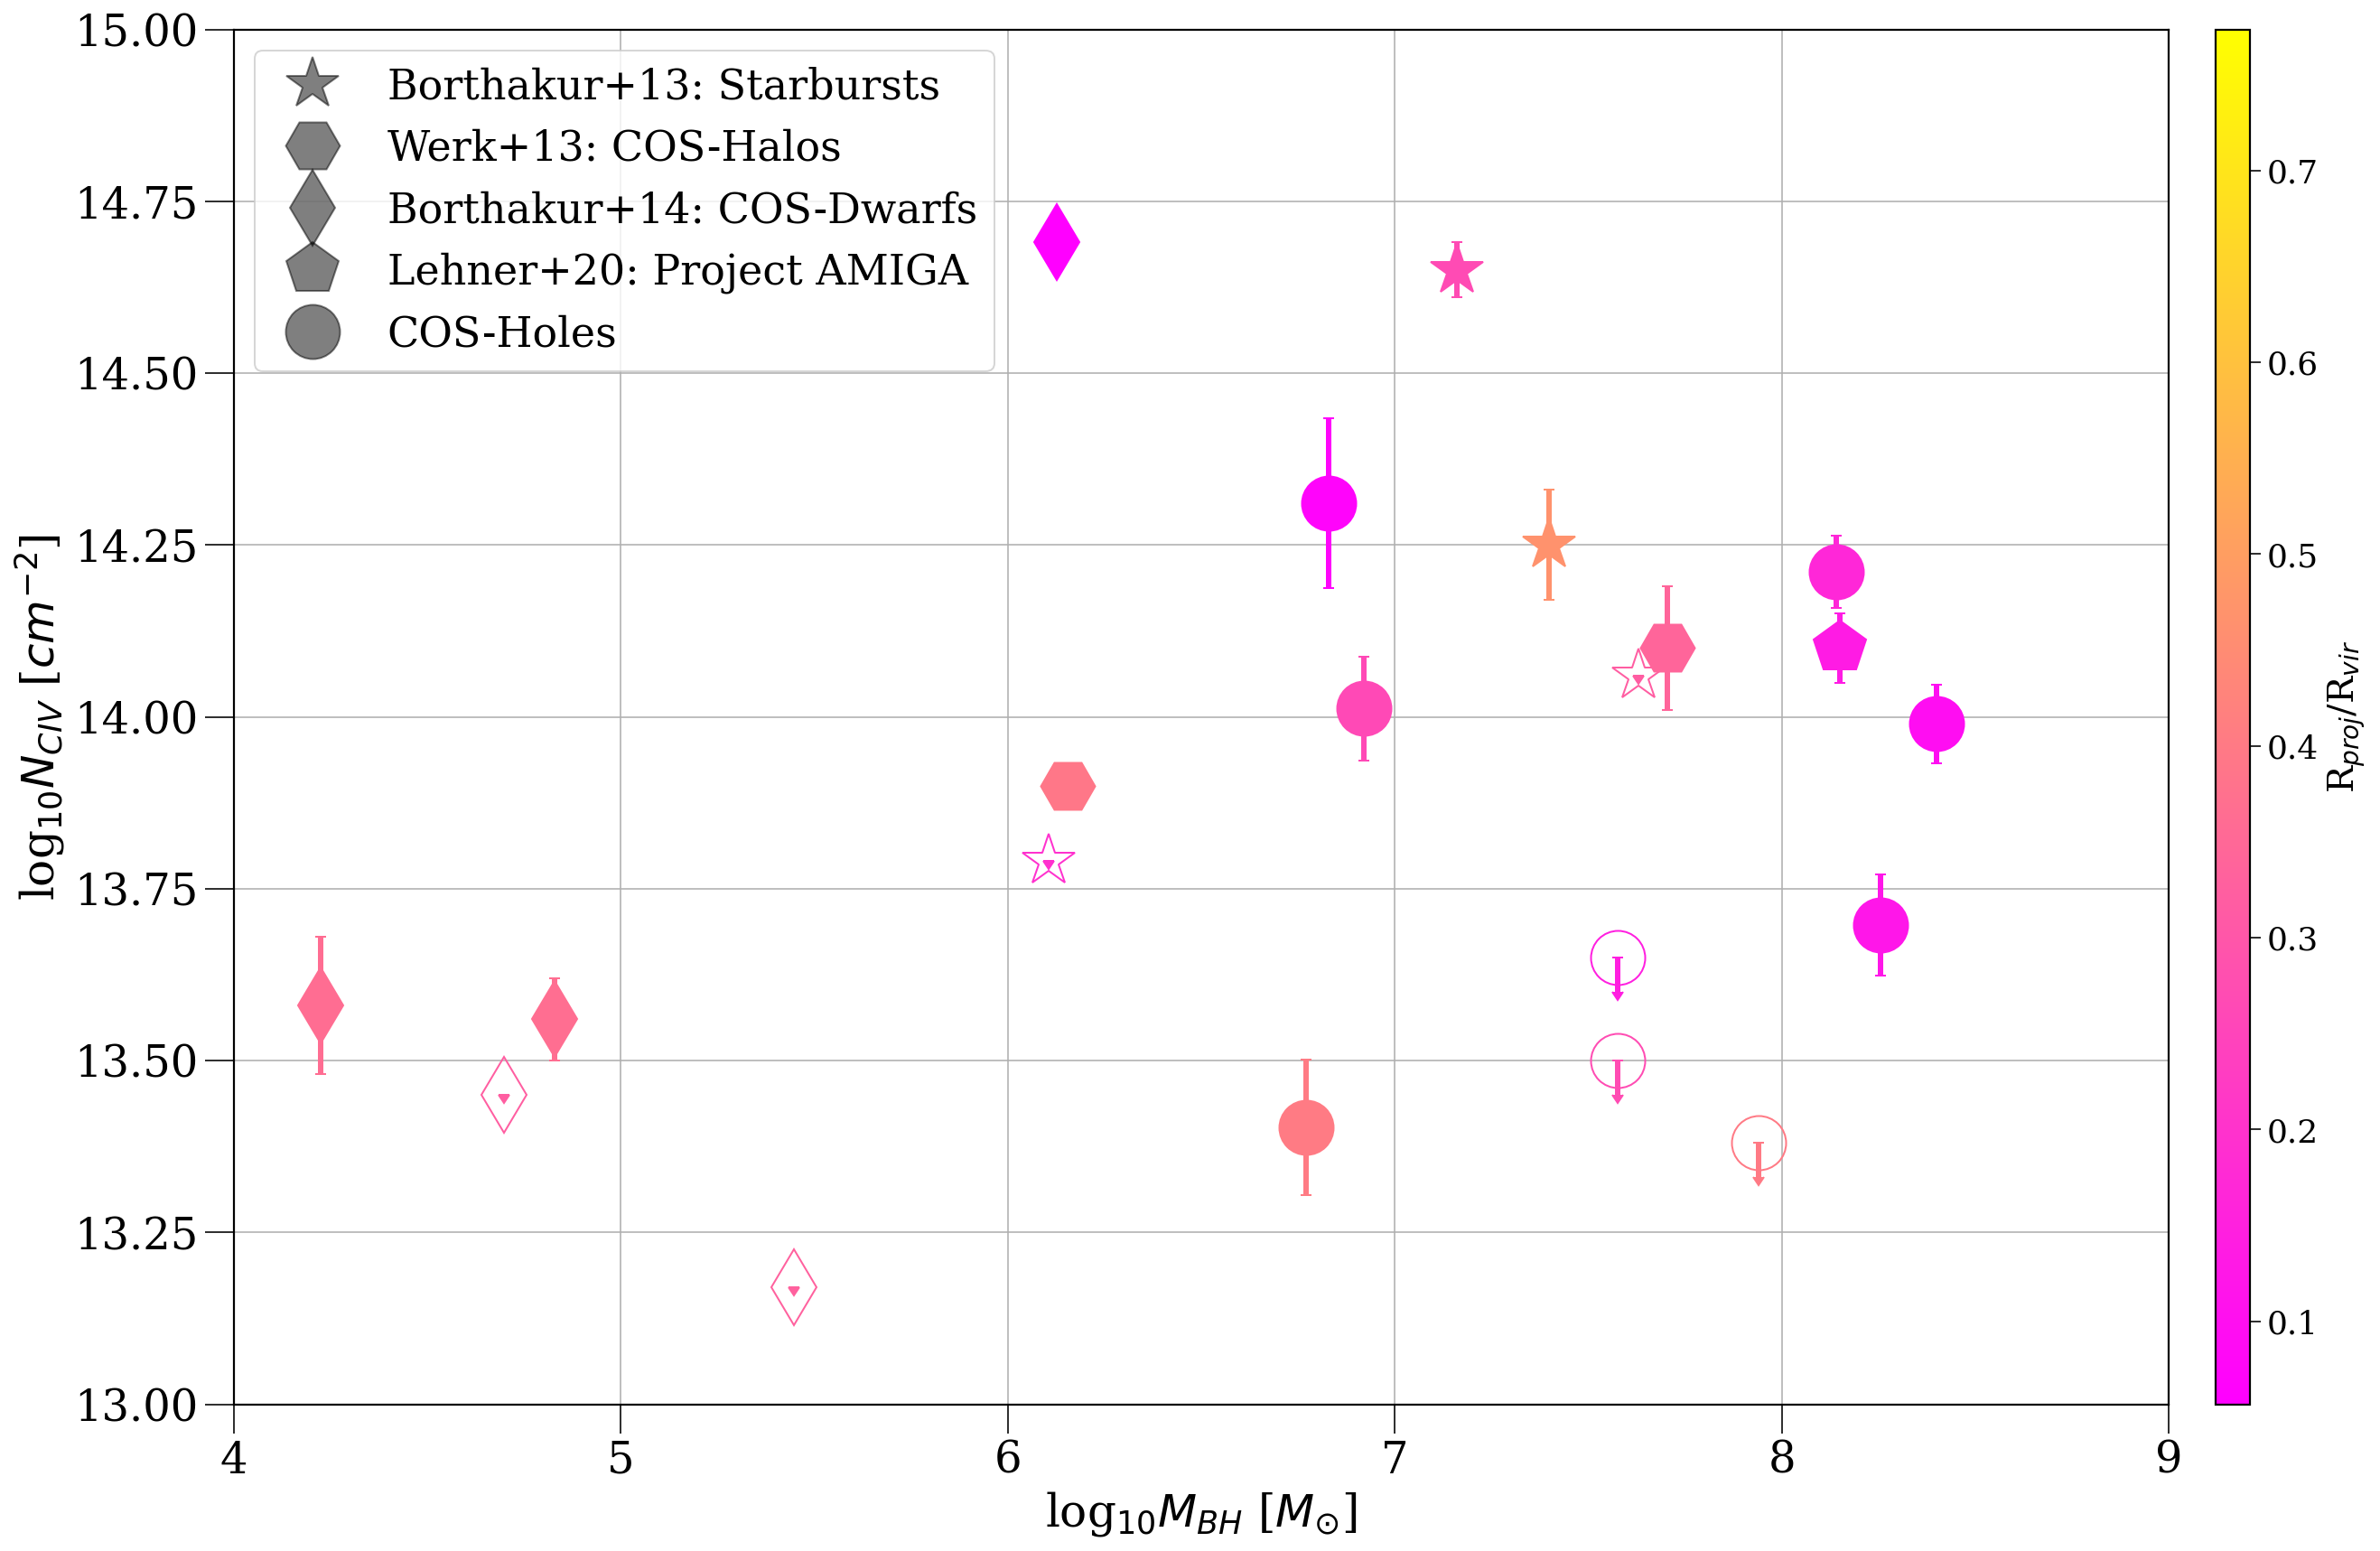

In [157]:
# ur gonna need this boi
import matplotlib as mpl

UL = np.array(coslit['uplim'])
has_UL = UL < 1

# Set figure size, I like this for 1 plot w colorbar but yaknow whateva
fig = plt.figure()

# Set a grid on your figure so you can define the color bar axis
# This is basically dividing your figure into rows,columns
# I put a lot of columns so the colorbar will be narrow
axs = fig.add_gridspec(1, 50)

# Define the plot and the colorbar axes
# This is totally up to preference, you could leave a column empty...
# ... if you wanted a little extra space between the two
# you just tell it width by the # of columns on the grid you define
# So basically play around with the grid (axs) and the subplots below...
# ... until you get a layout with dimensions you like
plot = fig.add_subplot(axs[0, 0:48]) # this means use cols 0 - 49
cbar = fig.add_subplot(axs[0, 49])

# Now lets get the colors for ur points, luckily you have the values ...
# ... you want the colors to correspond to defined above as array 'c'
# Then we will normalize the color bar to the min/max value of that...
# ... array so it looks nice
cool = plt.cm.get_cmap('spring')
# We need to make the c array be 0 -1 normalized so the colors are right
# This only needs to be done if you want the distance to be preserved as ...
# ... a gradient function of Rproj/Rvir
# since you have so few points though, that doesn't really matter
# so you could do a discrete color bar, which would just be equally spaced points ...
# ... spanning the entire range of the colorbar
# And the labels on the colorbar would indicate the value of Rproj/Rvir
# To do that, just replace "c_normed" with "np.linspace(0, 1, len(c))"
# below you'll see two colorbar display options that I've commented out
# One is discrete, only showing your points colors
# The other is a continous gradient which your points come from
# you'll see what I mean, just test it with each 'cmap' line below ...
# ... before you mess with this stuff if you decide you want it discrete

c = np.asarray(coslit['Rproj/Rvir'])
c_normed = (c-min(c))/(max(c)-min(c))
coloring = cool(c_normed) # you can replace plasma with whatev


# Okay now plotting, same as above but made the color our new defined one
# It gets mad at you without the loop cuz its dumb
# Because of the way you've defined your variables ...
# ... with pandas and masks, you need to make them arrays ...
# ... for this to work, which I did here
mbh_arr = np.array(coslit['MBH'])
N_arr = np.array(coslit['N'])
sigN_arr = np.array(coslit['sigN'])
sigmbh_arr = np.array(coslit['sigMBH'])
uplim_arr = np.array(coslit['uplim'])
marker_types = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o','o', 
                '*', '*', '*', '*', 
               'd', 'd', 'd', 'd', 'd', 
               'H', 'H', 
               'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']

#need to have unassigned shapes to represent the 4 datasets but not have them show up on the plot 
plot.plot(0,0, c='k', marker='*', markersize=30, ls='none', label='Borthakur+13: Starbursts', alpha=0.5)
plot.plot(0,0, c='k', marker='H', markersize=30, ls='none', label='Werk+13: COS-Halos', alpha=0.5)
plot.plot(0,0, c='k', marker='d', markersize=30, ls='none', label='Borthakur+14: COS-Dwarfs', alpha=0.5)
plot.plot(0,0, c='k', marker='p', markersize=30, ls='none', label='Lehner+20: Project AMIGA', alpha=0.5)
plot.plot(0,0, c='k', marker='o', markersize=30, ls='none', label='COS-Holes', alpha=0.5)  

    
for i in range(len(mbh_arr[:21])):
    if uplim_arr[i] < 1:  
        plot.errorbar(mbh_arr[i], N_arr[i], 
                yerr=sigN_arr[i],  
                capsize = 3, c=coloring[i], marker= marker_types[i], 
                markersize=30, ls='none', elinewidth=3, mfc='none', uplims=True)
    else: 
        plot.errorbar(mbh_arr[i], N_arr[i], 
                yerr=sigN_arr[i], 
                capsize = 3, c=coloring[i], marker=marker_types[i], 
                markersize=30, ls='none', elinewidth=3)
    
# I changed some of your sizes cause they looked too big with my code ig

# Here's where the magic happens
# Set up normalization for the color bar
# (sets lowest color to min value and highest color to max value)
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))

# make the color bar
#cmap = mpl.colors.ListedColormap(coloring, name='Rproj/Rvir')

# !!!!! Use this instead to make the colorbar look continuous gradient:
cmap = cool

# mapping for the color bar
mapping = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# do the thing, telling it to use the subplot you created for the ...
# ... color bar (cax = cbar)
colorbar = fig.colorbar(mapping, cax=cbar, orientation='vertical')

# Okay now it's created, the rest is just visual preference:
colorbar.ax.tick_params(length=6, labelsize=18)
colorbar.ax.spines['top'].set_linewidth(1.5)
colorbar.ax.spines['bottom'].set_linewidth(1.5)
colorbar.ax.spines['left'].set_linewidth(1.5)
colorbar.ax.spines['right'].set_linewidth(1.5)
colorbar.set_label(label=r'R$_{proj}$/R$_{vir}$', size=20)

# Your other stylings from above:
plot.legend(loc=2, fontsize=23) # Theres no labels for your legend but ill leave it
plot.set_xlabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=25)
plot.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=25)
plot.set_ylim([13, 15])
plot.set_xlim([4, 9])
plot.grid(True)
#plt.tight_layout()
plt.show()

### Trying to get different shapes and empty faces

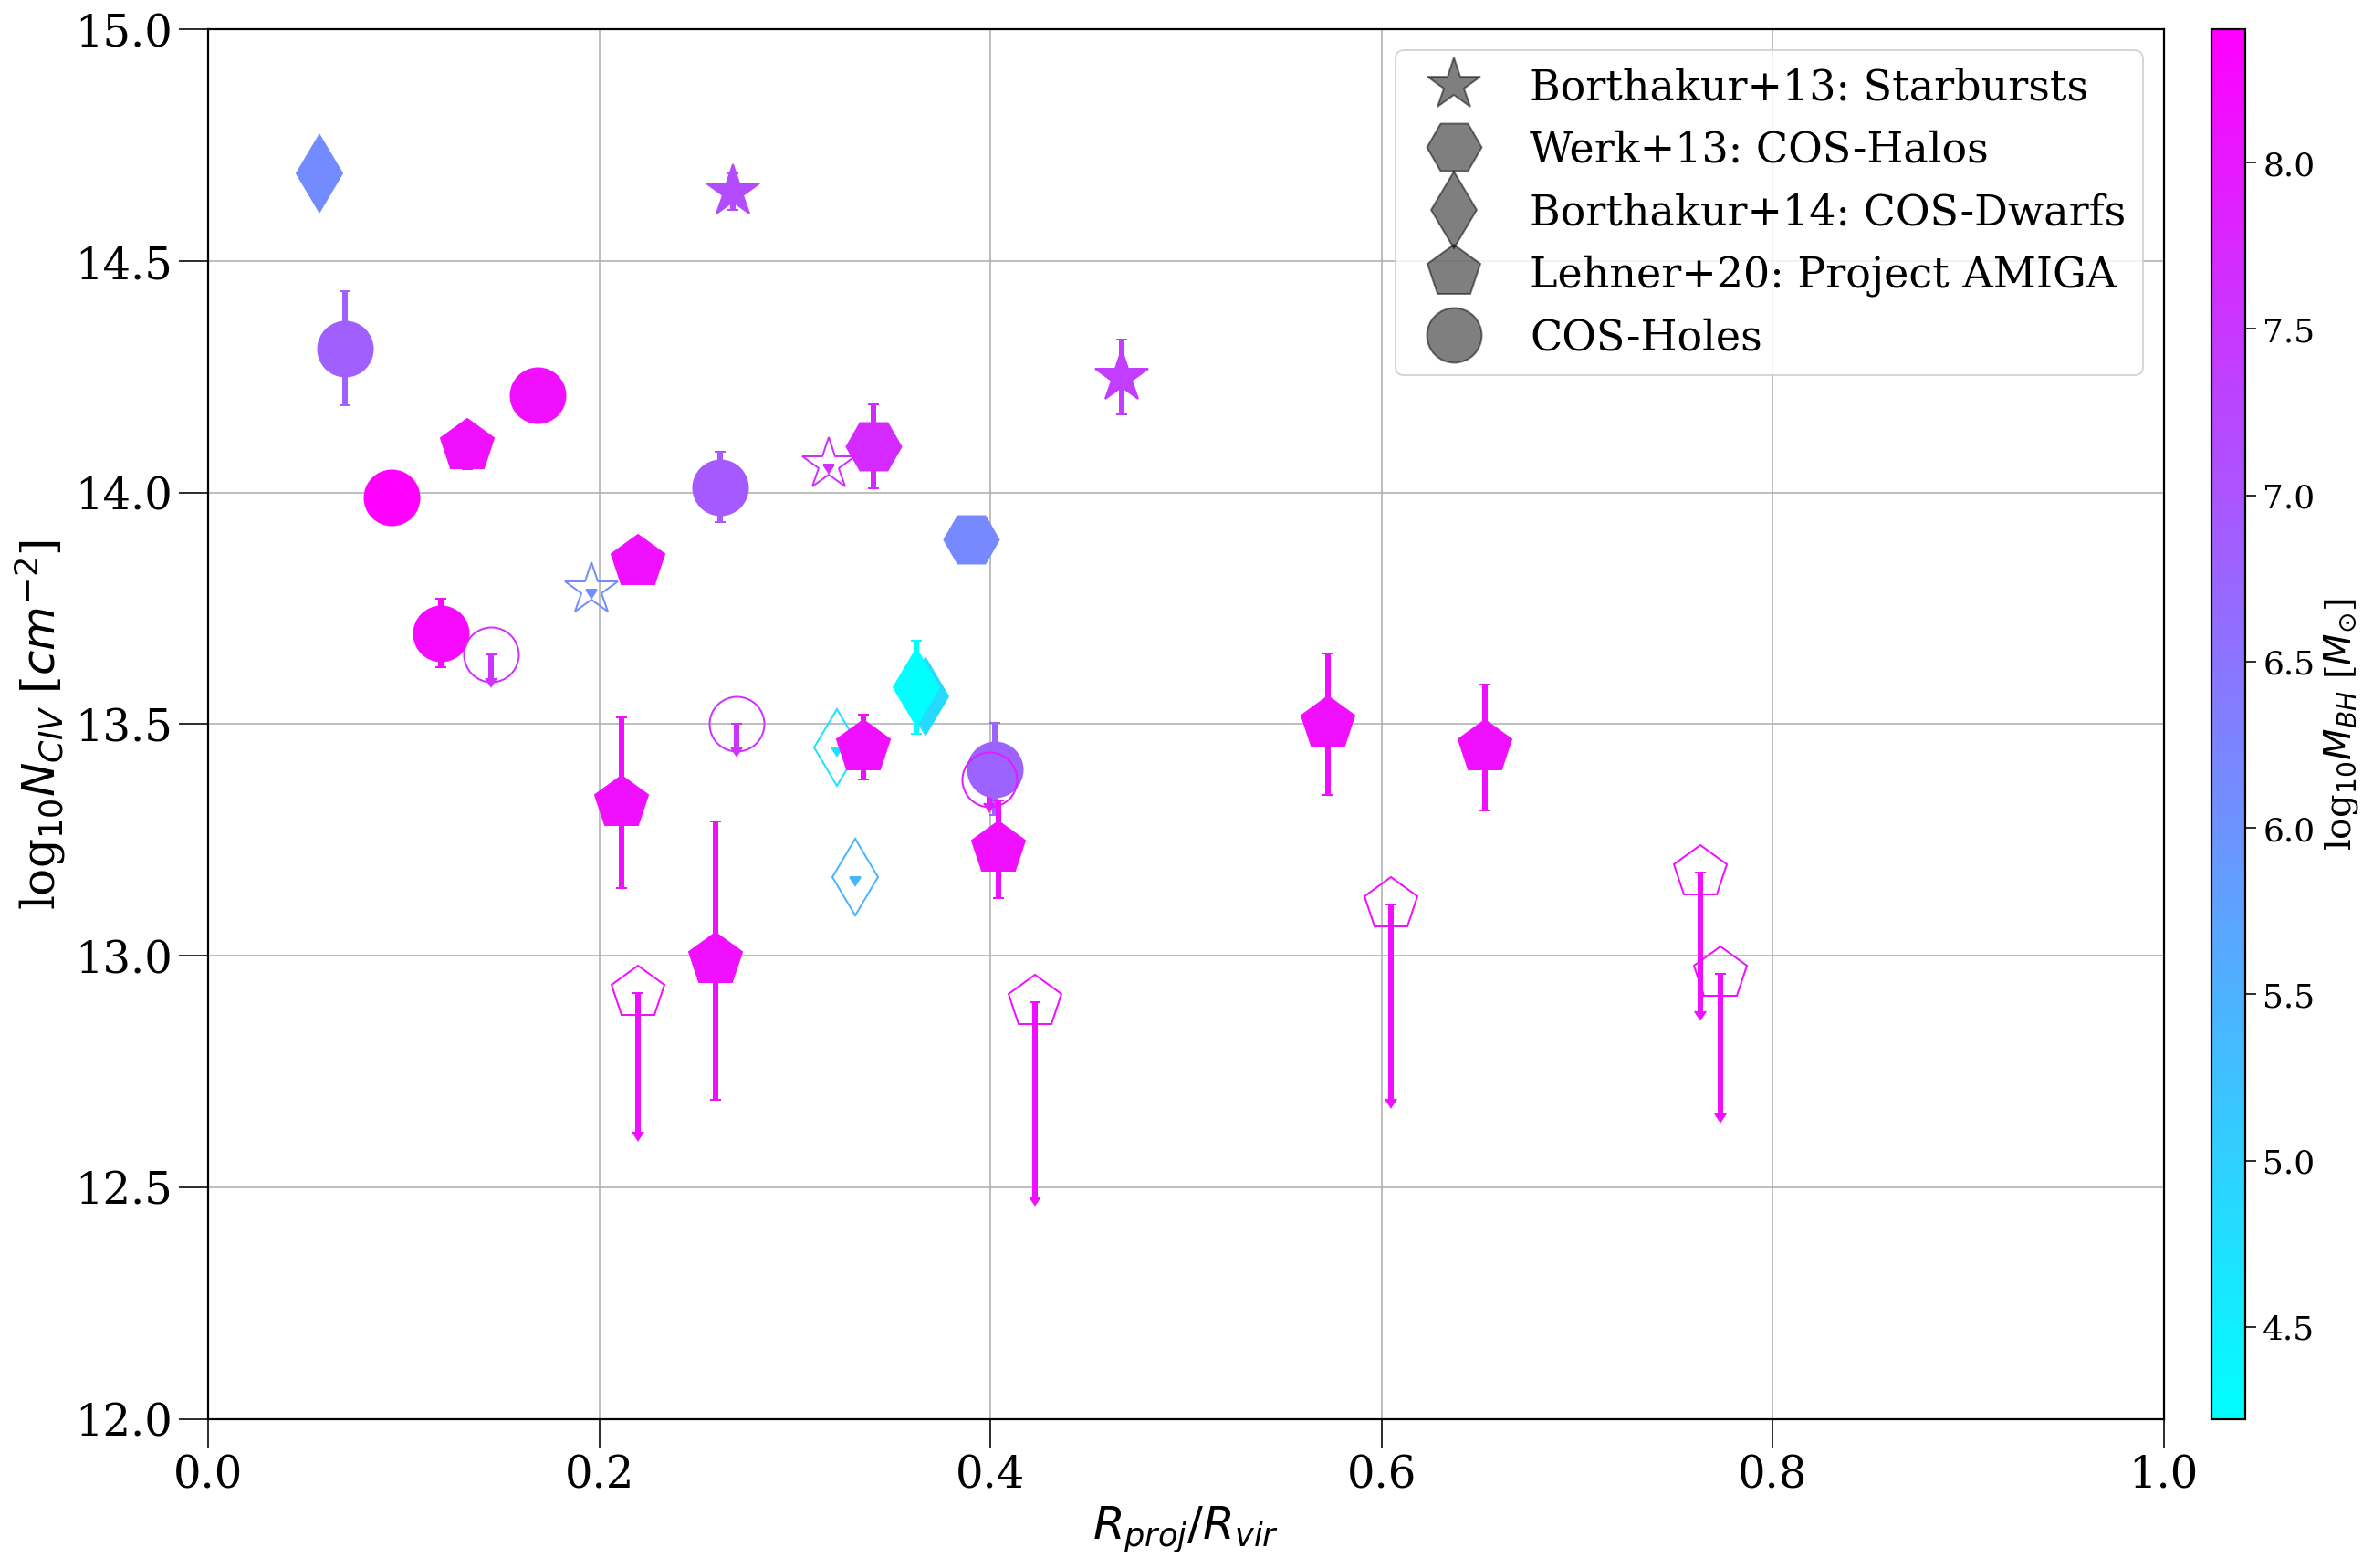

In [156]:
# Set figure size, I like this for 1 plot w colorbar but yaknow whateva
fig = plt.figure()

UL = np.array(coslit['uplim'])
has_UL = UL < 1

# Set a grid on your figure so you can define the color bar axis
# This is basically dividing your figure into rows,columns
# I put a lot of columns so the colorbar will be narrow
axs = fig.add_gridspec(1, 50)

# Define the plot and the colorbar axes
# This is totally up to preference, you could leave a column empty...
# ... if you wanted a little extra space between the two
# you just tell it width by the # of columns on the grid you define
# So basically play around with the grid (axs) and the subplots below...
# ... until you get a layout with dimensions you like
plot = fig.add_subplot(axs[0, 0:48]) # this means use cols 0 - 49
cbar = fig.add_subplot(axs[0, 49])

# Now lets get the colors for ur points, luckily you have the values ...
# ... you want the colors to correspond to defined above as array 'c'
# Then we will normalize the color bar to the min/max value of that...
# ... array so it looks nice
cool = plt.cm.get_cmap('cool')
# We need to make the c array be 0 -1 normalized so the colors are right
# This only needs to be done if you want the distance to be preserved as ...
# ... a gradient function of Rproj/Rvir
# since you have so few points though, that doesn't really matter
# so you could do a discrete color bar, which would just be equally spaced points ...
# ... spanning the entire range of the colorbar
# And the labels on the colorbar would indicate the value of Rproj/Rvir
# To do that, just replace "c_normed" with "np.linspace(0, 1, len(c))"
# below you'll see two colorbar display options that I've commented out
# One is discrete, only showing your points colors
# The other is a continous gradient which your points come from
# you'll see what I mean, just test it with each 'cmap' line below ...
# ... before you mess with this stuff if you decide you want it discrete

c = np.asarray(coslit['MBH'])
c_normed = (c-min(c))/(max(c)-min(c))
coloring = cool(c_normed) # you can replace plasma with whatev


# Okay now plotting, same as above but made the color our new defined one
# It gets mad at you without the loop cuz its dumb
# Because of the way you've defined your variables ...
# ... with pandas and masks, you need to make them arrays ...
# ... for this to work, which I did here
rr_arr = np.array(coslit['Rproj/Rvir'])
N_arr = np.array(coslit['N'])
sigN_arr = np.array(coslit['sigN'])
#sigmbh_arr = np.array(coslit['sigMBH'])
uplim_arr = np.array(coslit['uplim'])
marker_types = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o','o', #COS-Holes
                '*', '*', '*', '*', #Borthakur+2013: Starbursts
               'd', 'd', 'd', 'd', 'd', #Bordoloi+2014: COS-Dwarfs
               'H', 'H', #Werk+2013: COS-Halos
               'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'] #Lehner+2020: Project AMIGA

#need to have unassigned shapes to represent the 4 datasets but not have them show up on the plot 
plot.plot(0,0, c='k', marker='*', markersize=30, ls='none', label='Borthakur+13: Starbursts', alpha=0.5)
plot.plot(0,0, c='k', marker='H', markersize=30, ls='none', label='Werk+13: COS-Halos', alpha=0.5)
plot.plot(0,0, c='k', marker='d', markersize=30, ls='none', label='Borthakur+14: COS-Dwarfs', alpha=0.5)
plot.plot(0,0, c='k', marker='p', markersize=30, ls='none', label='Lehner+20: Project AMIGA', alpha=0.5)
plot.plot(0,0, c='k', marker='o', markersize=30, ls='none', label='COS-Holes', alpha=0.5)



for i in range(len(rr_arr)):
    if uplim_arr[i] < 1:  
        plot.errorbar(rr_arr[i], N_arr[i], 
                yerr=sigN_arr[i],  
                capsize = 3, c=coloring[i], marker= marker_types[i], 
                markersize=30, ls='none', elinewidth=3, mfc='none', uplims=True)
    else: 
        plot.errorbar(rr_arr[i], N_arr[i], 
                yerr=sigN_arr[i], 
                capsize = 3, c=coloring[i], marker=marker_types[i], 
                markersize=30, ls='none', elinewidth=3)
    
# I changed some of your sizes cause they looked too big with my code ig

# Here's where the magic happens
# Set up normalization for the color bar
# (sets lowest color to min value and highest color to max value)
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))

# make the color bar
#cmap = mpl.colors.ListedColormap(coloring, name='Rproj/Rvir')

# !!!!! Use this instead to make the colorbar look continuous gradient:
cmap = cool

# mapping for the color bar
mapping = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# do the thing, telling it to use the subplot you created for the ...
# ... color bar (cax = cbar)
colorbar = fig.colorbar(mapping, cax=cbar, orientation='vertical')

# Okay now it's created, the rest is just visual preference:
colorbar.ax.tick_params(length=6, labelsize=18)
colorbar.ax.spines['top'].set_linewidth(1.5)
colorbar.ax.spines['bottom'].set_linewidth(1.5)
colorbar.ax.spines['left'].set_linewidth(1.5)
colorbar.ax.spines['right'].set_linewidth(1.5)
colorbar.set_label(label=r'log$_{10}M_{BH}$ [$M_{\odot}$]', size=20)

# Your other stylings from above:
plot.legend(loc=1, fontsize=23) # Theres no labels for your legend but ill leave it
plot.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=25)
plot.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=25)
plot.set_ylim([12, 15])
plot.set_xlim([0, 1])
plot.grid(True)
#plt.tight_layout()
plt.show()